In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from torchvision import datasets, transforms
from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method
from cleverhans.torch.attacks.projected_gradient_descent import projected_gradient_descent
import torchvision.datasets as datasets
from tqdm import trange

In [2]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
# Set random seed for reproducibility
seed = 1234
# cuDNN uses nondeterministic algorithms, set some options for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(seed)

In [3]:
# Initial transform (convert to PyTorch Tensor only)
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_data = datasets.MNIST('data', train=True, download=True, transform=transform)
test_data = datasets.MNIST('data', train=False, download=True, transform=transform)

train_data.transform = transform
test_data.transform = transform

batch_size = 64

torch.manual_seed(seed)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=True) 
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=True)

Images shape:  torch.Size([64, 1, 28, 28])
Labels shape:  torch.Size([64])
Mean=0.1332315057516098, Std=0.3099796175956726


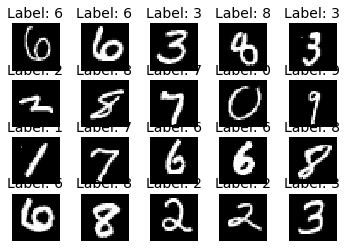

<Figure size 864x720 with 0 Axes>

In [4]:
images, labels = next(iter(train_loader))

# Print information and statistics of the first batch of images
print("Images shape: ", images.shape)
print("Labels shape: ", labels.shape)
print(f'Mean={images.mean()}, Std={images.std()}')


# Randomly sample 20 images of the training dataset
# To visualize the i-th sample, use the following code
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.imshow(images[i].squeeze(), cmap='gray', interpolation='none')
    plt.title(f'Label: {labels[i]}', fontsize=14)
    plt.axis('off')
figure = plt.figure(figsize=(12, 10))
cols, rows = 10, 10
plt.show()

In [5]:
input_size = 1 * 28 * 28  # input spatial dimension of images
hidden_size = 128         # width of hidden layer
output_size = 10          # number of output neurons

class MNISTClassifierMLP(torch.nn.Module):
    
    def __init__(self):
        
        super().__init__()
        self.flatten = torch.nn.Flatten(start_dim=1)
        self.fc1 = torch.nn.Linear(28*28, 512) 
        self.act = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(512,10)

        # ------------------
    
    def forward(self, x):
        # Input image is of shape [batch_size, 1, 28, 28]
        # Need to flatten to [batch_size, 784] before feeding to fc1
        x = self.flatten(x)
        out = self.fc1(x)
        out = self.act(out)
        out = self.fc2(out)
        y_output = torch.nn.functional.log_softmax(out, dim=1)
        
        return y_output
        # ------------------

model = MNISTClassifierMLP().to(DEVICE)

# sanity check
print(model)

MNISTClassifierMLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (act): ReLU()
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)


In [6]:
from torchsummary import summary
summary(model, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
              ReLU-3                  [-1, 512]               0
            Linear-4                   [-1, 10]           5,130
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 1.55
Estimated Total Size (MB): 1.57
----------------------------------------------------------------


In [7]:
def train_one_epoch(train_loader, model, device, optimizer, log_interval, epoch):
    model.train()
    losses = []
    counter = []
    
    for i, (img, label) in enumerate(train_loader):
        img, label = img.to(device), label.to(device)
        optimizer.zero_grad()
        output = model(img)
        loss = torch.nn.functional.nll_loss(output, label)
        loss.backward()
        optimizer.step()
    
        # Record training loss every log_interval and keep counter of total training images seen
        if (i+1) % log_interval == 0:
            losses.append(loss.item())
            counter.append(
                (i * batch_size) + img.size(0) + epoch * len(train_loader.dataset))

    return losses, counter

In [8]:
def test_one_epoch(test_loader, model, device, attack=None):
    model.eval()
    test_loss = 0
    num_correct = 0

    # torch.set_grad_enabled(False)
    # with torch.no_grad():
    for i, (img, label) in enumerate(test_loader):
        img, label = img.to(device), label.to(device)
        if attack == 'fgm':
            img = fast_gradient_method(model, img, eps=0.1, norm=np.inf)
        if attack == 'pgd':
            img = projected_gradient_descent(model, img, eps=0.1, eps_iter=0.01,nb_iter=40, norm=np.inf)
        
        # prediction
        pred = model(img).max(1)[1] # Get index of largest log-probability and use that as prediction
        num_correct += pred.eq(label).sum().item()
        
        # sum all test losses
        output = model(img)
        loss = torch.nn.functional.nll_loss(output, label)
        test_loss += loss.item()
    # get average of test losses
    test_loss /= len(test_loader.dataset)
    return test_loss, num_correct


In [9]:
# Hyperparameters
lr = 0.01
max_epochs=5
gamma = 0.95

# Recording data
log_interval = 100

# Instantiate optimizer (model was created in previous cell)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

train_losses = []
train_counter = []

test_losses = []
test_losses_fgm = []
test_losses_pgd = []

test_correct = []
test_correct_fgm = []
test_correct_pgd = []
for epoch in trange(max_epochs, leave=True, desc='Epochs'):
    train_loss, counter = train_one_epoch(train_loader, model, DEVICE, optimizer, log_interval, epoch)
    train_losses.extend(train_loss)
    train_counter.extend(counter)
    
    # Record results normal
    test_loss, num_correct = test_one_epoch(test_loader, model, DEVICE)
    test_correct.append(num_correct)
    test_losses.append(test_loss)
    # Record results fgm
    test_loss_fgm, num_correct_fgm = test_one_epoch(test_loader, model, DEVICE, attack='fgm')
    test_correct_fgm.append(num_correct_fgm)
    test_losses_fgm.append(test_loss_fgm)
    # Record results pdg
    test_loss_pgd, num_correct_pdg = test_one_epoch(test_loader, model, DEVICE, attack='pgd')
    test_correct_pgd.append(num_correct_pdg)
    test_losses_pgd.append(test_loss_pgd)

Epochs: 100%|██████████| 5/5 [03:36<00:00, 43.31s/it]


In [10]:
print(f"Test accuracy for base model: {test_correct[-1]/len(test_loader.dataset)}")
print(f"Test accuracy with fast gradient training attack: {test_correct_fgm[-1]/len(test_loader.dataset)}")
print(f"Test accuracy with projected gradient descent attack: {test_correct_pgd[-1]/len(test_loader.dataset)}")


Test accuracy for base model: 0.9163
Test accuracy with fast gradient training attack: 0.2045
Test accuracy with projected gradient descent attack: 0.153


In [11]:
print(f"Test loss for base model: {test_losses[-1]}")
print(f"Test loss with fast gradient training attack: {test_losses_fgm[-1]}")
print(f"Test loss with projected gradient descent attack: {test_losses_pgd[-1]}")


Test loss for base model: 0.00466711176391691
Test loss with fast gradient training attack: 0.04087607539892197
Test loss with projected gradient descent attack: 0.04646299030780792


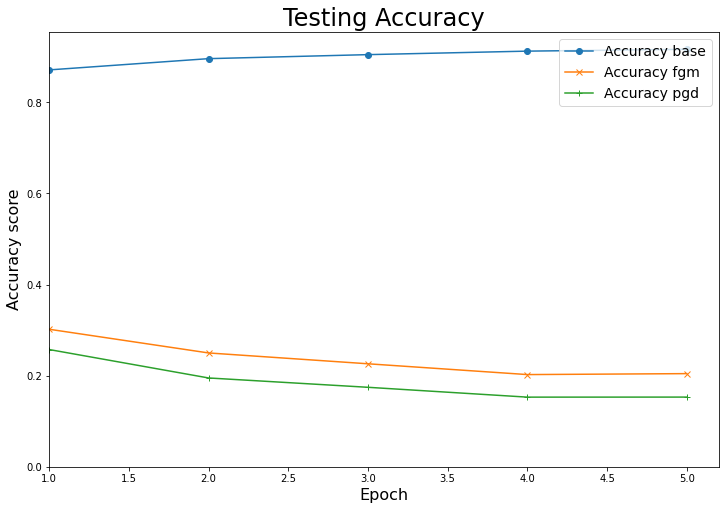

In [12]:
# Draw testing accuracy curves
fig = plt.figure(figsize=(12,8))
plt.plot([i for i in range(1, max_epochs + 1)], [i/len(test_loader.dataset) for i in test_correct], label='Accuracy base', marker='o')
plt.plot([i for i in range(1, max_epochs + 1)], [i/len(test_loader.dataset) for i in test_correct_fgm], label='Accuracy fgm', marker='x')
plt.plot([i for i in range(1, max_epochs + 1)], [i/len(test_loader.dataset) for i in test_correct_pgd], label='Accuracy pgd', marker='+')
plt.xlim(left=1)
plt.ylim(bottom=0)
plt.title('Testing Accuracy', fontsize=24)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Accuracy score', fontsize=16)
plt.legend(loc='upper right', fontsize=14)

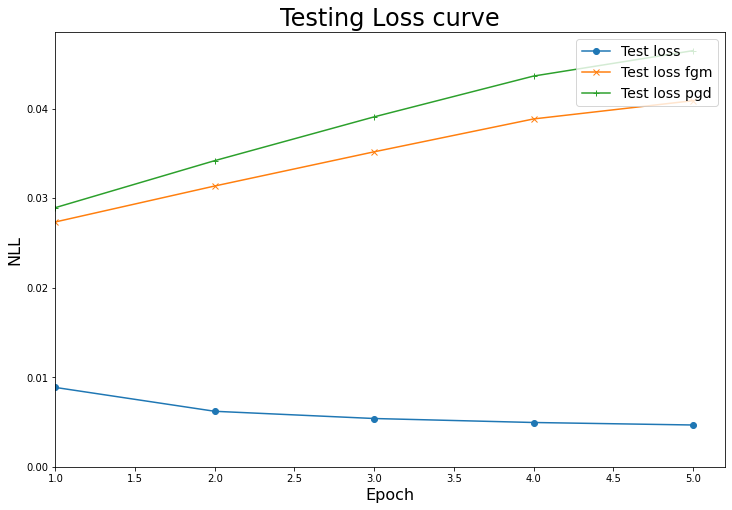

In [13]:
# 1. Draw training loss curve
fig = plt.figure(figsize=(12,8))
# plt.plot(train_counter, train_losses, label='Train loss')
plt.plot([i for i in range(1, max_epochs + 1)], 
         test_losses, label='Test loss', marker='o')
plt.plot([i for i in range(1, max_epochs + 1)], 
         test_losses_fgm, label='Test loss fgm', marker='x')
plt.plot([i for i in range(1, max_epochs + 1)], 
         test_losses_pgd, label='Test loss pgd', marker='+')
plt.xlim(left=1)
plt.ylim(bottom=0)
plt.title('Testing Loss curve', fontsize=24)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('NLL', fontsize=16)
plt.legend(loc='upper right', fontsize=14)

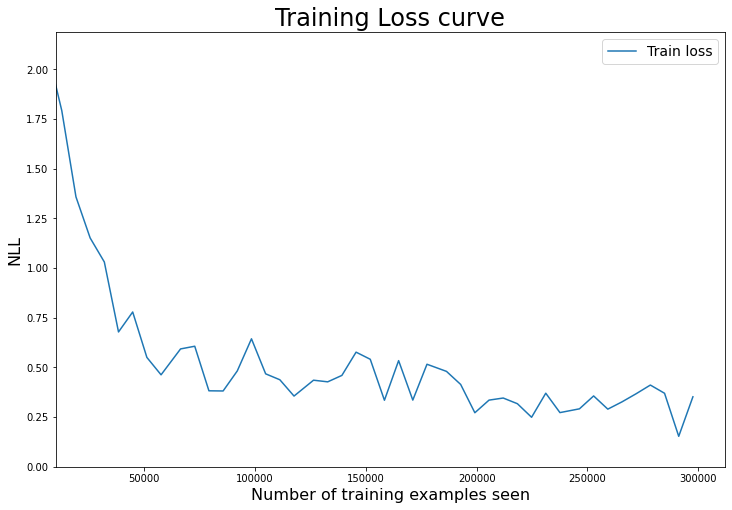

In [14]:
# 1. Draw training loss curve
fig = plt.figure(figsize=(12,8))
plt.plot(train_counter, train_losses, label='Train loss')
plt.xlim(left=10000)
plt.ylim(bottom=0)
plt.title('Training Loss curve', fontsize=24)
plt.xlabel('Number of training examples seen', fontsize=16)
plt.ylabel('NLL', fontsize=16)
plt.legend(loc='upper right', fontsize=14)

In [15]:
def adv_train_one_epoch(train_loader, model, device, optimizer, log_interval, epoch):
    model.train()
    losses = []
    counter = []
    
    for i, (img, label) in enumerate(train_loader):
        # normal training
        img, label = img.to(device), label.to(device)
        optimizer.zero_grad()
        output = model(img)
        loss = torch.nn.functional.nll_loss(output, label)
        loss.backward()
        optimizer.step()
 
        # adverserial training against fgm and pgd
        img_fgm = fast_gradient_method(model, img, eps=0.1, norm=np.inf)
        optimizer.zero_grad()
        output = model(img_fgm)
        loss = torch.nn.functional.nll_loss(output, label)
        loss.backward()
        optimizer.step()
        
        img_pgd = projected_gradient_descent(model, img, eps=0.1, eps_iter=0.01,nb_iter=40, norm=np.inf)
        optimizer.zero_grad()
        output = model(img_pgd)
        loss = torch.nn.functional.nll_loss(output, label)
        loss.backward()
        optimizer.step()
        
        # Record training loss every log_interval and keep counter of total training images seen
        if (i+1) % log_interval == 0:
            losses.append(loss.item())
            counter.append(
                (i * batch_size) + img.size(0) + epoch * len(train_loader.dataset))
    return losses, counter

In [16]:
# Hyperparameters
lr = 0.01
max_epochs=5
gamma = 0.95

# Recording data
log_interval = 100

# Instantiate optimizer (model was created in previous cell)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

train_losses = []
train_counter = []

test_losses = []
test_losses_fgm = []
test_losses_pgd = []

test_correct = []
test_correct_fgm = []
test_correct_pgd = []
for epoch in trange(max_epochs, leave=True, desc='Epochs'):
    train_loss, counter = adv_train_one_epoch(train_loader, model, DEVICE, optimizer, log_interval, epoch)
    train_losses.extend(train_loss)
    train_counter.extend(counter)
    
    # Record results normal
    test_loss, num_correct = test_one_epoch(test_loader, model, DEVICE)
    test_correct.append(num_correct)
    test_losses.append(test_loss)
    # Record results fgm
    test_loss_fgm, num_correct_fgm = test_one_epoch(test_loader, model, DEVICE, attack='fgm')
    test_correct_fgm.append(num_correct_fgm)
    test_losses_fgm.append(test_loss_fgm)
    # Record results pdg
    test_loss_pgd, num_correct_pdg = test_one_epoch(test_loader, model, DEVICE, attack='pgd')
    test_correct_pgd.append(num_correct_pdg)
    test_losses_pgd.append(test_loss_pgd)

Epochs: 100%|██████████| 5/5 [12:45<00:00, 153.08s/it]


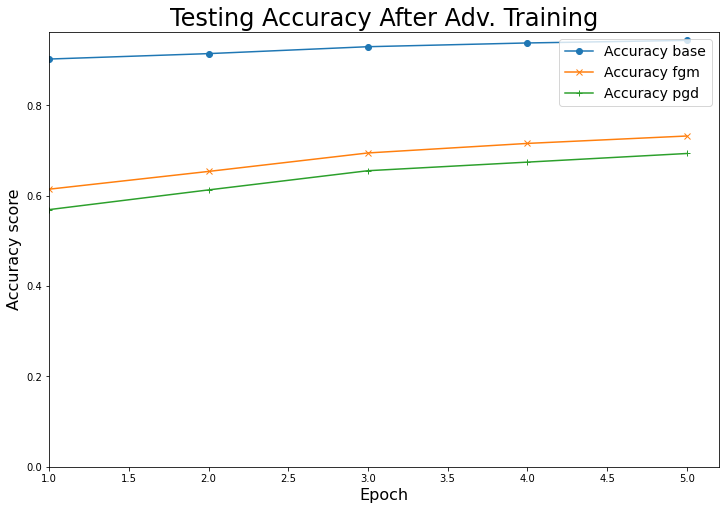

In [17]:
# Draw testing accuracy curves
fig = plt.figure(figsize=(12,8))
plt.plot([i for i in range(1, max_epochs + 1)], [i/len(test_loader.dataset) for i in test_correct], label='Accuracy base', marker='o')
plt.plot([i for i in range(1, max_epochs + 1)], [i/len(test_loader.dataset) for i in test_correct_fgm], label='Accuracy fgm', marker='x')
plt.plot([i for i in range(1, max_epochs + 1)], [i/len(test_loader.dataset) for i in test_correct_pgd], label='Accuracy pgd', marker='+')
plt.xlim(left=1)
plt.ylim(bottom=0)
plt.title('Testing Accuracy After Adv. Training', fontsize=24)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Accuracy score', fontsize=16)
plt.legend(loc='upper right', fontsize=14)

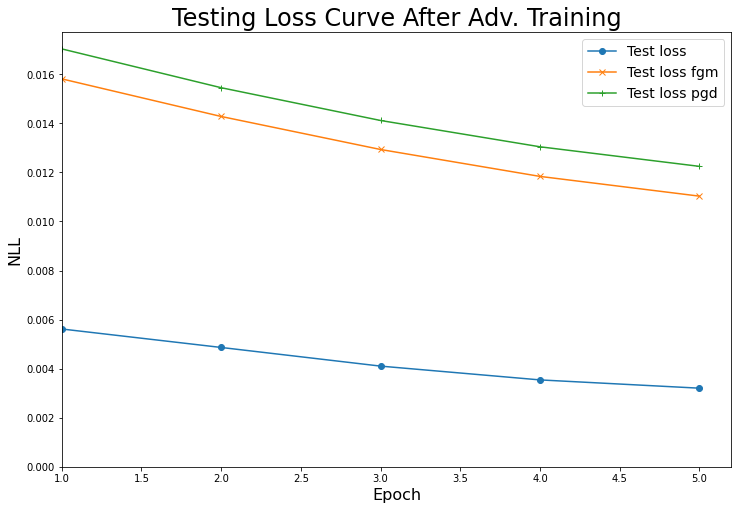

In [18]:
fig = plt.figure(figsize=(12,8))
plt.plot([i for i in range(1, max_epochs + 1)], 
         test_losses, label='Test loss', marker='o')
plt.plot([i for i in range(1, max_epochs + 1)], 
         test_losses_fgm, label='Test loss fgm', marker='x')
plt.plot([i for i in range(1, max_epochs + 1)], 
         test_losses_pgd, label='Test loss pgd', marker='+')
plt.xlim(left=1)
plt.ylim(bottom=0)
plt.title('Testing Loss Curve After Adv. Training', fontsize=24)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('NLL', fontsize=16)
plt.legend(loc='upper right', fontsize=14)

In [19]:
print(f"Test accuracy for base model after adv. training: {test_correct[-1]/len(test_loader.dataset)}")
print(f"Test accuracy against fast gradient training attack after adv. training: {test_correct_fgm[-1]/len(test_loader.dataset)}")
print(f"Test accuracy against projected gradient descent attack after adv. training: {test_correct_pgd[-1]/len(test_loader.dataset)}")

Test accuracy for base model after adv. training: 0.9436
Test accuracy against fast gradient training attack after adv. training: 0.732
Test accuracy against projected gradient descent attack after adv. training: 0.6933


In [20]:
print(f"Test loss for base model: {test_losses[-1]}")
print(f"Test loss with fast gradient training attack: {test_losses_fgm[-1]}")
print(f"Test loss with projected gradient descent attack: {test_losses_pgd[-1]}")

Test loss for base model: 0.003204622370749712
Test loss with fast gradient training attack: 0.011032073107361793
Test loss with projected gradient descent attack: 0.012246349132061005
